<a href="https://colab.research.google.com/github/eleanorjolliffe/Capstone-2025/blob/main/Capstone_Analysis_Part_1_TF_IDF_%26_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary libraries

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import numpy as np
import glob
import spacy
import re

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#TF-IDF - Unigrams & Bigrams

In [ ]:
reddit = pd.read_csv('/content/clean_reddit_ulez.csv')
telegram = pd.read_csv('/content/clean_telegram_ulez.csv')

In [ ]:
# defining some words to remove which add little to the analysis
words_to_remove = set([
    'yep', 'dont', 'get', 'like', 'would', 'one', 'im', 'think', 'even', 'thats', 'also', 'going',
    'cant', 'much', 'youre', 'theres', 'things', 'arent', 'might', 'bit', 'yeah', 'since', 'seems',
    'either', 'wouldnt', 'time', 'make', 'really', 'doesnt', 'want', 'isnt', 'way', 'didnt', 'back',
    'yes', 'k', 'said', 'ive', 'already', 'sure', 'this', 'though', 'lot', 'every', 'know', 'bring',
    'day', 'told', 'sent', 'per', 'nothing', 'havent', 'seen', 'anyone', 'guess', 'today', 'ooh',
    'youll','copy', 'paste', 'proposed', 'let', 'see', 'many', 'could', 'take', 'got', 'use', 'people',
    'work', 'case', 'next', 'us', 'pm', 'th', 'thank', 'anything', 'please', 'new', 'need', 'go',
    'stop', 'well', 'good', 'say', 'never', 'join', 'come', 'may', 'keep', 'another', 'put', 'must',
    'years', 'first', 'year', 'still', 'last', 'everyone', 'end', 'around', 'give', 'made', 'etc',
    'wont', 'look', 'station', 'act', 'done', 'used', 'without', 'send', 'number', 'start', 'part',
    'home', 'g', 'big', 'rd', 'away', 'best', 'high', 'thing', 'thanks', 'coming', 'getting', 'using',
    'two', 'far', 'st', 'little', 'foward', 'week', 'notice', 'note', 'stand', 'something', 'show',
    'group', 'system', 'groups', 'house', 'better', 'ask', 'making', 'enough', 'theyre', 'name',
    'forward', 'live', 'someone', 'point', 'sat', 'always', 'full', 'yet'
])

stop_words = set(stopwords.words('english'))

The function, preprocess_text, firstly tokenises all text into individual words and filters out stop words. Next, it filters out words I have predefined to remove if remove_extra is used. Finally, it returns words in a single space-separated string.

The following function, get_top_ngrams, first sets remove_extra to True when analysing single words (this removes additional unwanted words but is not done for bigrams, as it would remove useful context for words often seen together). Following this, the preprocess_text function is applied to the data. Next, a TF-IDF vectoriser is created, which accounts for the n-gram range. This transforms the cleaned data into a matrix of TF-IDF scores and computes the sum of scores for each n-gram across all documents. Finally, a new DataFrame is created with n-grams and their corresponding scores, sorted in descending order by score. The top n-grams and scores are then returned.


In [ ]:
def preprocess_text(text, remove_extra_words=False):
    words = nltk.word_tokenize(text)
    filtered = [w for w in words if w.isalnum() and w not in stop_words]
    if remove_extra_words:
        filtered = [w for w in filtered if w not in words_to_remove]
    return " ".join(filtered)

def get_top_ngrams(corpus, ngram_range=(1,1), top_n=100):
    remove_extra = True if ngram_range == (1,1) else False
    processed_corpus = [preprocess_text(doc, remove_extra) for doc in corpus]
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(processed_corpus)
    sums = tfidf_matrix.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()

    ranking = pd.DataFrame({'term': terms, 'tfidf': sums})
    return ranking.sort_values(by='tfidf', ascending=False).head(top_n)

In [ ]:
#applying the functions for unigrams and bigrams
reddit_unigrams = get_top_ngrams(reddit['clean_message'], ngram_range=(1,1), top_n=100)
reddit_bigrams = get_top_ngrams(reddit['clean_message'], ngram_range=(2,2), top_n=100)

telegram_unigrams = get_top_ngrams(telegram['clean_message'], ngram_range=(1,1), top_n=100)
telegram_bigrams = get_top_ngrams(telegram['clean_message'], ngram_range=(2,2), top_n=100)

In [ ]:
#saving the results as CSVs
telegram_unigrams.to_csv('telegram_unigrams.csv', index=False)
telegram_bigrams.to_csv('telegram_bigrams.csv', index=False)
reddit_unigrams.to_csv('reddit_unigrams.csv', index=False)
reddit_bigrams.to_csv('reddit_bigrams.csv', index=False)

In [ ]:
#defining climate related words and bigrams seen in the top TF-IDF scores
climate_keywords = [
    'climate', 'emission', 'emissions', 'environment', 'air quality', 'clean air', 'poor air quality',
    'pollution', 'green', 'carbon', 'co2', 'sustainability', 'climate change', 'net zero',
    'sustainable', 'reduce emissions', 'improve air quality', 'air', 'diesel', 'petrol cars',
    'improving air quality', 'poor air quality', 'improve air quality', 'air quality london',
    'london air quality', 'air pollution', 'petrol', 'cleaner air', 'electric cars', 'london air',
    'polluting vehicles', 'air', 'polluting', 'electric', 'climate con', 'cars'
]

In [ ]:
# This function plots the TF-IDF results but ensures climate-related words are in colour while non-climate words aren't
def plot_climate_coloured_wordcloud(df, title, climate_terms=climate_keywords):
    frequencies = dict(zip(df['term'], df['tfidf']))
    def color_func(word, *args, **kwargs):
        if word in climate_terms:
            return random.choice(['green', 'blue', 'darkgreen', 'teal'])
        else:
            return random.choice(['dimgray', 'gray', 'darkgray'])

    wc = WordCloud(width=900, height=450, background_color='white', color_func=color_func)
    wc.generate_from_frequencies(frequencies)

    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

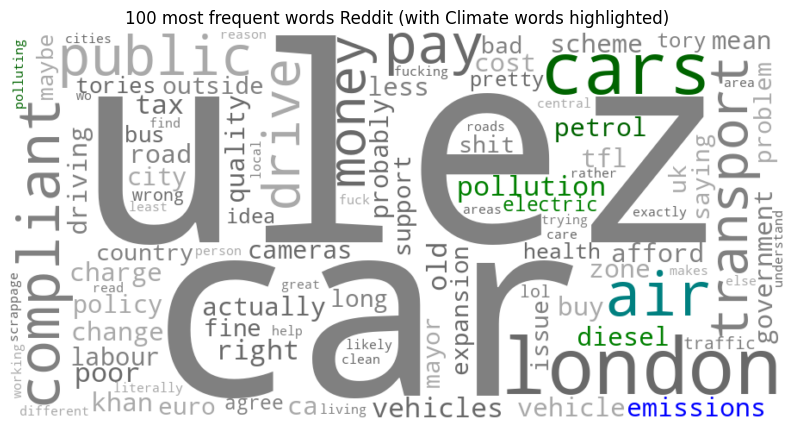

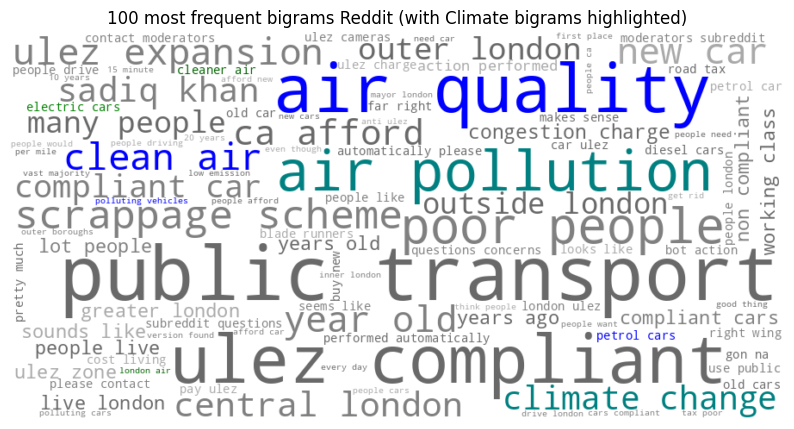

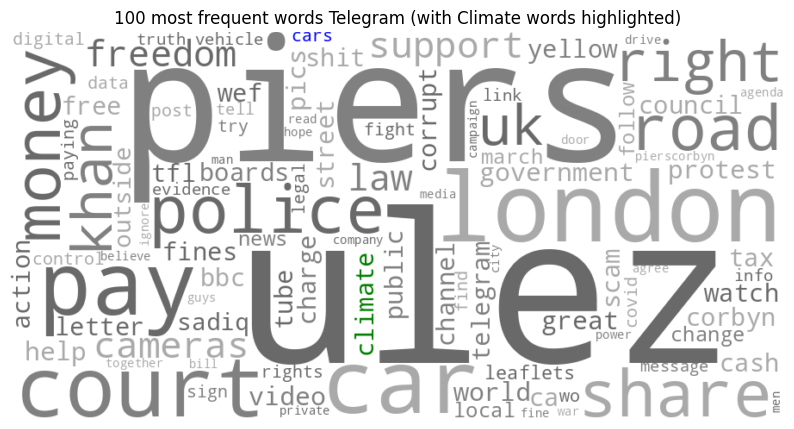

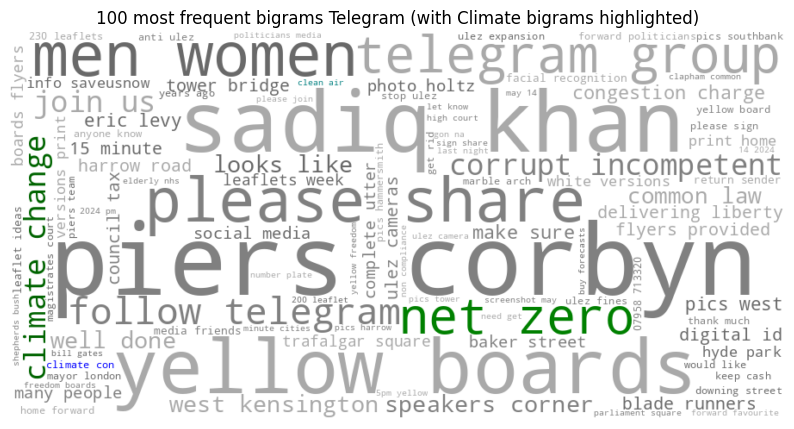

In [ ]:
#plotting results by calling the function
plot_climate_coloured_wordcloud(reddit_unigrams, '100 most frequent words Reddit (with Climate words highlighted)')
plot_climate_coloured_wordcloud(reddit_bigrams, '100 most frequent bigrams Reddit (with Climate bigrams highlighted)')

plot_climate_coloured_wordcloud(telegram_unigrams, '100 most frequent words Telegram (with Climate words highlighted)')
plot_climate_coloured_wordcloud(telegram_bigrams, '100 most frequent bigrams Telegram (with Climate bigrams highlighted)')

#Topic Modelling

##Running BERTopic

In [ ]:
!pip install bertopic
from bertopic import BERTopic
import json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

This is a BERTopic model for both Reddit data and Telegram data using all miniLM, a lightweight and fast sentence transformer model. Each model converts the text into dense vector embeddings which capture the semantic meaning of the text.


In [ ]:
#applying BERTopic to my data for topic modelling
reddit_model = BERTopic(embedding_model="all-MiniLM-L6-v2")
telegram_model = BERTopic(embedding_model="all-MiniLM-L6-v2")

In [ ]:
#This uses the predefined model and applies it to the clean messages. BERTopic converts each message into a dense vector, then clusters
#(continued) these vectors and extracts topics / key terms from every cluster.
telegram_topics, telegram_probs = telegram_model.fit_transform(telegram['clean_message'])

In [ ]:
from google.colab import files

telegram_topic_info = telegram_model.get_topic_info()
telegram_topic_info.to_csv('telegram_topic_info.csv', index=False)
files.download('telegram_topic_info.csv')

In [ ]:
#Again, this uses the predefined Reddit model and applies it to the clean messages. BERTopic converts each message into a dense vector, then
#(continued) clusters these vectors and extracts topics / key terms from every cluster.
reddit_topics, reddit_probs = reddit_model.fit_transform(reddit['clean_message'])

In [ ]:
reddit_topic_info = reddit_model.get_topic_info()

reddit_topic_info.to_csv('reddit_topic_info.csv', index=False)
files.download('reddit_topic_info.csv')

##Assigning Topic Names

In [ ]:
#plotting the top 20 telegram topics and their representative words
telegram_fig1 = telegram_model.visualize_barchart(top_n_topics=20, n_words=20, title='Telegram Top 20 topics and their representative words')

In [ ]:
telegram_fig1

In [ ]:
telegram_fig1.write_html('telegram_fig1.html')

In [ ]:
#This was used to investigate the keywords and representative documents associated with each theme, which helped manually assign topic names
#The same was done with Reddit, but was excluded to avoid repetition
telegram_model.get_topic_info().head()
telegram_model.get_topic(0)
telegram_model.get_representative_docs(0)

In [ ]:
telegram_topic_names = ["N/A", "Anti-COVID-19 vaccine language and misinformation",
                        "Anti-surveillance & ULEZ camera resistance",
                        "Letter writing & sending discourse",
                        "Anti-ULEZ discourse", "5G & 4G conspiracy",
                        "Personal data privacy concerns",
                        "Climate Change scepticism",
                        "Russia-Ukraine War discourse, NATO critique and conspiracy",
                        "Council tax discourse", "General corruption and incompetence rhetoric",
                        "Freedom rally organising",
                        "ULEZ price outrage & endorsement of camera destruction",
                        "TFL legality scepticism", "Penalty charge notice discourse",
                        "Pro-farmers’ rights", "Pseudo-legal strategies to avoid authority",
                        "Anti-cashless society discourse and organising",
                        "ULEZ-compliant vehicle service promotion", "ULEZ fines discussion",
                        "Forcibly removed vehicle discussion"
]

In [ ]:
#creating a dataframe of the top 20 telegram topics and renaming them with my manually generated names
twenty_top_telegram_topics = telegram_model.get_topic_info().head(21)
twenty_top_telegram_topics = twenty_top_telegram_topics.drop(columns=['Topic', 'Name', 'CustomName'], axis=1)
twenty_top_telegram_topics['Assigned Topic Name'] = telegram_topic_names

In [ ]:
#plotting the top 20 reddit topics and their representative words
reddit_fig1 = reddit_model.visualize_barchart(top_n_topics=20, n_words=20, title='Reddit Top 20 topics and their representative words')

In [ ]:
reddit_fig1

In [ ]:
reddit_topic_names = ["N/A", "UK Politics discourse",
                      "Air quality, emissions, climate & ULEZ discourse",
                      "Anti-surveillance & ULEZ camera frustration",
                      "Mixed opinion electric vehicle discourse",
                      "Diesel and petrol vehicles pollution discourse",
                      "Sadiq Khan and UK Politics discussion",
                      "Urban-Rural Inequity in the ULEZ Policy",
                      "Mixed opinion public transport discussion",
                      "Administrative load and disproportionate ULEZ penalties",
                      "Pratical discourse on the least polluting cars",
                      "ULEZ camera destruction & vandalism discourse",
                      "ULEZ scrappage scheme discourse", "ULEZ opinion and definition conversation",
                      "Tradesmen's vans ULEZ compliance discourse",
                      "Terrorism definitions and discussion", "Cycling infrastructure mixed discourse",
                      "London city discussion", "Positioning ULEZ as a tax on the poor",
                      "Discourse arguing poor people can't afford cars",
                      "Crime and Policing discourse"
]

In [ ]:
#creating a dataframe of the top 20 reddit topics and renaming them with my manually generated names
twenty_top_reddit_topics = reddit_model.get_topic_info().head(21)
twenty_top_reddit_topics = twenty_top_reddit_topics.drop(columns=['Topic', 'Name'], axis=1)
twenty_top_reddit_topics['Assigned Topic Name'] = reddit_topic_names

##Comparative Analysis

In [ ]:
#dropping the first row, topic -1, this is often incorrect and random, made up of outliers
telegram_pie = twenty_top_telegram_topics.drop([0])

In [ ]:
#dropping the first row, topic -1, this is often incorrect and random, made up of outliers
reddit_pie = twenty_top_reddit_topics.drop([0])

In [ ]:
#creating a new column which calculates the percentage a given theme makes up of the top 20 themes
reddit_pie['% of the top 20 themes this theme makes up'] = (reddit_pie['Count'] / reddit_pie['Count'].sum())*100
telegram_pie['% of the top 20 themes this theme makes up'] = (telegram_pie['Count'] / telegram_pie['Count'].sum())*100

In [ ]:
#using plotly, this plots the percentage each theme makes up (of the top 20 themes) on a pie chart with the percentage and theme stored as hover data
import plotly.express as px
fig = px.pie(telegram_pie,
             values='% of the top 20 themes this theme makes up',
             names='Assigned Topic Name',
             title="% of each theme in the top 20 ULEZ Telegram Topics",
             hover_data={'% of the top 20 themes this theme makes up': True, 'Assigned Topic Name': True})

fig.update_traces(textinfo='percent', insidetextorientation='radial',
                  hovertemplate='%{label}: %{value:.2f}%')
fig.update_layout(legend_title_text='Assigned Topics', legend=dict(orientation="v", x=1, y=0.5))

fig.show()

In [ ]:
#using plotly, this plots the percentage each theme makes up (of the top 20 themes) on a pie chart with the percentage and theme stored as hover data
fig = px.pie(reddit_pie,
             values='% of the top 20 themes this theme makes up',
             names='Assigned Topic Name',
             title="% of each theme in the top 20 ULEZ Reddit Topics",
             hover_data={'% of the top 20 themes this theme makes up': True, 'Assigned Topic Name': True})

fig.update_traces(textinfo='percent', hovertemplate='%{label}: %{value:.2f}%')
fig.update_layout(legend_title_text='Assigned Topics', legend=dict(orientation="v", x=1, y=0.5))

fig.show()